# Start of the file
-   Global scale factor, use abs min of 95 and 5 percentile
-   model training, training / validation as 0.9/0.1 splitting 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from collections import Counter
from sklearn.ensemble import IsolationForest

from sklearn.neighbors import LocalOutlierFactor
import hdbscan
import os
import torch
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
import pickle
from sklearn.model_selection import train_test_split

print(torch.__version__)
print(torch.cuda.is_available())  # Check if CUDA is available (if using GPU)
print(torch.cuda.device_count())  # Check how many GPUs are available
print(torch.cuda.get_device_name(0))  # Get the name of the first GPU
print(torch.cuda.current_device())  # Get the current GPU device

# Check if cuDNN is enabled
print(torch.backends.cudnn.enabled)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)


2.6.0+cu118
True
1
NVIDIA GeForce RTX 4060 Ti
0
True
cuda:0


# Preprocess

In [ ]:
with open("files_dataframe.pickle", "rb") as f:
  files_dataframe = pickle.load(f)



In [ ]:

def preprocess_lcs_with_uncertainty(df, set='train'):
    """Enhanced preprocessing that incorporates uncertainties"""
    
    df = df[~df['tess_flux'].isna() & ~df['tess_uncert'].isna()]
    df = df.copy(deep=True)
    oids = np.unique(df['object_name'])
    
    data = []
    uncertainties = []
    weights = []
    target_class = []
    oids_used = []

    p999 = np.percentile(df['tess_flux'], 99.9)
    p001 = np.percentile(df['tess_flux'], 0.1)  
    p95 = np.percentile(df['tess_flux'], 95)
    p05 = np.percentile(df['tess_flux'], 5)  
    print(f"=== Using 0.1 and 99.9 percentiles for clipping ===")
    print(f"p999: {p999}, p001: {p001}")
    print(f"=== Using 5 and 95 percentiles for scaling ===")
    print(f"p95: {p95}, p05: {p05}")
    
    scale_factor = min([abs(p05), p95])
    print(f"Scale factor: {scale_factor}")


    for oid in oids:
        lc = df[df['object_name'] == oid].copy(deep=True)
        
        # see all extremely flux > 1.1e6 to 1.1e6
        lc.loc[lc['tess_flux'] > p999, 'tess_flux'] = p999
        lc.loc[lc['tess_flux'] < p001, 'tess_flux'] = p001

        # Normalize flux and handle uncertainties
        lc['tess_flux'] = lc['tess_flux'] / scale_factor
        lc['tess_uncert'] = lc['tess_uncert'] / scale_factor  # Scale uncertainties similarly
        
        # Calculate weights based on inverse uncertainty
        lc['weight'] = 1.0 / (lc['tess_uncert'] + 1e-6)
        lc['weight'] = lc['weight'] / lc['weight'].max()  # Normalize
        
        lc['time'] = lc['relative_time'] - np.nanmin(lc['relative_time'])
        
        if len(lc) > 100:
            lc = lc.sample(100)
        
        if len(lc) < 20:
            continue
        
        data.append(lc[['time', 'tess_flux']].values)
        uncertainties.append(lc[['time', 'tess_uncert']].values)
        weights.append(lc['weight'].values)
        target_class.append(lc['object_name'].values[0])
        oids_used.append(oid)
    
    return oids_used, target_class, data, uncertainties, weights

all_ids, all_labels, all_data, all_uncertainties, all_weights = preprocess_lcs_with_uncertainty(files_dataframe)

=== Using 0.1 and 99.9 percentiles for clipping ===
p999: 875048.2907651206, p001: -587315.5075081089
=== Using 5 and 95 percentiles for scaling ===
p95: 9909.940456622871, p05: -4987.499168638303
Scale factor: 4987.499168638303


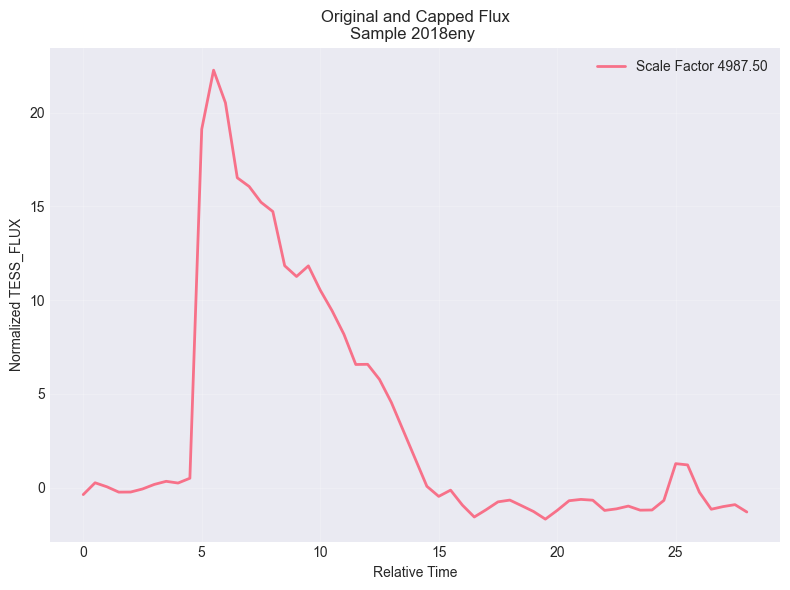

In [18]:
from scipy.stats import median_abs_deviation
from tqdm import tqdm

from src.util import preprocess_lcs_per_object

label_name = '2018eny'
# label_name = '2019kli'
# label_name = '2021soz'
# label_name = '20200fyf'
# label_name = '2019bgp'

df = files_dataframe.copy()
df = df[df['object_name']==label_name]
df = df[~df['tess_flux'].isna() & ~df['tess_uncert'].isna()]

data = {}
orig_data = []

p999 = 875048.2907651206
p001 = -587315.5075081089
scale_factor = 4987.499168638303

def preprocess_lcs_per_object1(df, set='train'):
    """Enhanced preprocessing that incorporates uncertainties"""
    
    for i in [1]:
        lc = df.copy(deep=True)
        
        # see all extremely flux > 1.1e6 to 1.1e6
        lc.loc[lc['tess_flux'] > p999, 'tess_flux'] = p999
        lc.loc[lc['tess_flux'] < p001, 'tess_flux'] = p001

        # Normalize flux and handle uncertainties
        lc['tess_flux'] = lc['tess_flux'] / scale_factor
        lc['tess_uncert'] = lc['tess_uncert'] / scale_factor  # Scale uncertainties similarly
        
        # Calculate weights based on inverse uncertainty
        lc['weight'] = 1.0 / (lc['tess_uncert'] + 1e-6)
        lc['weight'] = lc['weight'] / lc['weight'].max()  # Normalize
        
        lc['time'] = lc['relative_time'] - np.nanmin(lc['relative_time'])

        data = np.column_stack([lc['time'].values, lc['tess_flux'].values])
        # orig_data = np.column_stack([lc['time'].values, df['tess_flux'].values])

    return data

# capped_count = []

# for k in [3, 5, 10, 15, 25]:
output = preprocess_lcs_per_object1(df )
# output
plt.figure(figsize=(8, 6))

# Plot with minimal styling
# plt.plot(orig_data[:, 0], orig_data[:, 1], 'b--', linewidth=2.5, label='Original Data')

for k in [25]:
# k=25
    recon_data = output
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='-', label=f'Scale Factor {scale_factor:.2f}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Capped Flux\nSample {label_name} ')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()


In [5]:
class UncertaintyAwareLCDataset(Dataset):
    def __init__(self, data, uncertainties, weights, targets, ids, transform=None):
        self.data = data
        self.uncertainties = uncertainties
        self.weights = weights
        self.targets = targets
        self.ids = ids
        self.lengths = [len(seq) for seq in data]
        self.transform = transform

    def __getitem__(self, index):
        data = self.data[index]
        uncertainty = self.uncertainties[index]
        weights = self.weights[index]
        targets = self.targets[index]
        ids = self.ids[index]
        lengths = self.lengths[index]

        if self.transform:
            data = self.transform(data)
            uncertainty = self.transform(uncertainty)

        return data, uncertainty, weights, targets, ids, lengths

    def __len__(self):
        return len(self.data)

def uncertainty_collate_fn(batch):
    """Enhanced collate function that handles uncertainties and weights"""
    
    data, uncertainties, weights, targets, ids, lengths = zip(*batch)

    # Convert sequences to tensors and pad them
    sequences = [torch.tensor(d, dtype=torch.float32) for d in data]
    padded_sequences = pad_sequence(sequences, batch_first=True)
    
    # Pad uncertainties
    uncertainty_sequences = [torch.tensor(u, dtype=torch.float32) for u in uncertainties]
    padded_uncertainties = pad_sequence(uncertainty_sequences, batch_first=True)
    
    # Pad weights
    weight_sequences = [torch.tensor(w, dtype=torch.float32) for w in weights]
    padded_weights = pad_sequence(weight_sequences, batch_first=True)

    # Convert other data to tensors
    targets = torch.tensor(targets)
    ids = torch.tensor(ids)
    lengths = torch.tensor(lengths)

    return padded_sequences, padded_uncertainties, padded_weights, targets, ids, lengths

# Create enhanced datasets and data loaders
all_ds = UncertaintyAwareLCDataset(
    all_data, all_uncertainties, all_weights,
    [all_labels.index(id) for id in all_labels], 
    [all_ids.index(id) for id in all_ids]
)

all_loader = DataLoader(
    all_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

all_loader_no_shuffle = DataLoader(
    all_ds,
    batch_size=128,
    num_workers=0,
    shuffle=False,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

In [6]:
train_ids, val_ids, train_labels, val_labels, train_data, val_data, \
train_uncertainties, val_uncertainties, train_weights, val_weights = train_test_split(all_ids, all_labels, all_data, 
                                                    all_uncertainties, all_weights, test_size=0.1, random_state=42)

train_final_ids = [train_ids.index(id) for id in train_ids]
train_final_labels = [train_labels.index(id) for id in train_labels]

train_ds = UncertaintyAwareLCDataset(train_data, train_uncertainties, train_weights,
                                     [train_labels.index(id) for id in train_labels], [train_ids.index(id) for id in train_ids])
train_loader = DataLoader(
    train_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

val_ds = UncertaintyAwareLCDataset(val_data, val_uncertainties, val_weights,
                                   [val_labels.index(id) for id in val_labels], [val_ids.index(id) for id in val_ids] )
val_loader = DataLoader(
    val_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

# training

In [8]:
from src.util import Encoder, Decoder

class UncertaintyAwareRNN_VAE(torch.nn.Module):
    """RNN-VAE that incorporates measurement uncertainties"""
    
    def __init__(self, input_size=2, hidden_size=64, latent_size=16, dropout=0.2):
        super(UncertaintyAwareRNN_VAE, self).__init__()
        self.device = device
        
        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 4
        self.dropout = dropout
        
        self.enc = Encoder(input_size=input_size, hidden_size=hidden_size, 
                          num_layers=self.num_layers, dropout=self.dropout)
        
        self.dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            dropout=self.dropout,
            num_layers=self.num_layers,
        )
        
        self.fc21 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = torch.nn.Linear(self.latent_size, self.hidden_size)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu
    
    def forward(self, x, lengths, weights=None):
        batch_size, seq_len, feature_dim = x.shape
        
        # encode input space
        enc_output, enc_hidden = self.enc(x, lengths)
        
        # Correctly accessing the hidden state of the last layer
        enc_h = enc_hidden[-1].to(device)
        
        # extract latent variable z
        mu = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparameterize(mu, logvar)
        
        # initialize hidden state
        h_ = self.fc3(z)
        h_ = h_.unsqueeze(0)
        h_ = h_.repeat(self.dec.num_layers, 1, 1)
        
        # decode latent space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len, self.latent_size).to(device)
        
        # initialize hidden state
        hidden = h_.contiguous()
        x_hat, hidden = self.dec(z, hidden)
        
        return x_hat, mu, logvar

def uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights=None):
    """ELBO loss with uncertainty weighting"""
    
    # Reconstruction loss with uncertainty weights
    if weights is not None:
        # Expand weights to match x shape if needed
        if weights.dim() == 2:  # [batch_size, seq_len]
            weights = weights.unsqueeze(-1)  # [batch_size, seq_len, 1]
        
        # Weighted MSE
        weighted_MSE = torch.sum(weights * (x_hat - x)**2)
    else:
        weighted_MSE = torch.nn.MSELoss(reduction='sum')(x_hat, x)
    
    # KL divergence (unchanged)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return weighted_MSE + KLD

In [9]:
# def train_uncertainty_aware_vae(hidden_size=128, latent_size=16, nepochs=800):

from pathlib import Path
from src.util import save_checkpoint, plot_model_loss


hidden_size=128
latent_size=16
nepochs = 600
num_layers = 4

# save checkpoint every 20 epochs 
checkpoint_increment = 20

# Create a single folder
checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_val_uncert_v20251213")
checkpoint_path.mkdir(parents=True, exist_ok=True)
print(f"checkpoint_path: {checkpoint_path}")

"""Training function that incorporates uncertainties"""

model = UncertaintyAwareRNN_VAE(hidden_size=hidden_size, latent_size=latent_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-4)

training_losses = []
validation_losses = []

<>:16: SyntaxWarning: invalid escape sequence '\R'
<>:16: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_28488\4256778842.py:16: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_val_uncert_v20251213")


checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_val_uncert_v20251213


<>:16: SyntaxWarning: invalid escape sequence '\R'
<>:71: SyntaxWarning: invalid escape sequence '\R'
<>:16: SyntaxWarning: invalid escape sequence '\R'
<>:71: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_42416\818240056.py:16: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_val_uncert_v20251213")
C:\Users\xuesh\AppData\Local\Temp\ipykernel_42416\818240056.py:71: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'


checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_val_uncert_v20251213
Beginning uncertainty-aware training...
Epoch 0 | Train: 11739.59 | Val: 11051.83
Epoch 1 | Train: 10111.31 | Val: 8464.69
Epoch 2 | Train: 8079.27 | Val: 7323.21
Epoch 3 | Train: 7308.04 | Val: 6862.75
Epoch 4 | Train: 6927.90 | Val: 6562.39
Epoch 5 | Train: 6651.90 | Val: 6315.63
Epoch 6 | Train: 6418.93 | Val: 6097.71
Epoch 7 | Train: 6210.54 | Val: 5899.01
Epoch 8 | Train: 6016.29 | Val: 5710.86
Epoch 9 | Train: 5833.52 | Val: 5534.40
Epoch 10 | Train: 5660.61 | Val: 5366.71
Epoch 11 | Train: 5498.16 | Val: 5207.26
Epoch 12 | Train: 5332.34 | Val: 5017.95
Epoch 13 | Train: 5058.33 | Val: 4479.03
Epoch 14 | Train: 4207.97 | Val: 3514.98
Epoch 15 | Train: 3451.91 | Val: 3454.61
Epoch 16 | Train: 3263.16 | Val: 3447.45
Epoch 17 | Train: 3235.77 | Val: 3211.89
Epoch 18 | Train: 3218.03 | Val: 3167.93
Epoch 19 | Train: 3207.88 | Val: 3236.26
Checkpoint saved at epoch 20 in the file: checkpoint\RNN_VAE_lat16_hid12

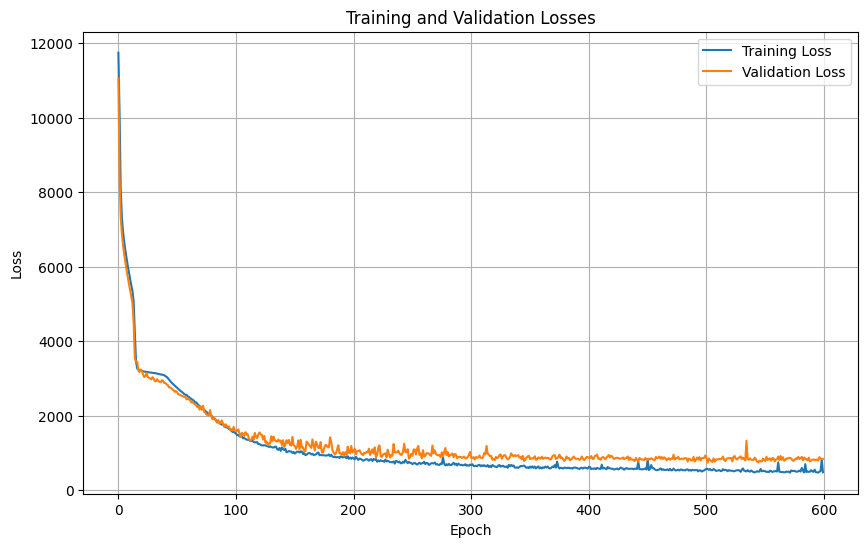

In [ ]:


print("Beginning uncertainty-aware training...")
for epoch in range(nepochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for x, uncertainties, weights, labels, ids, lengths in train_loader:
        x = x.to(device)
        weights = weights.to(device)
        
        x_hat, mu, logvar = model(x, lengths)
        loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    training_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in val_loader:
            x = x.to(device)
            weights = weights.to(device)
            
            x_hat, mu, logvar = model(x, lengths)
            loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    validation_losses.append(avg_val_loss)

    print(f'Epoch {epoch} | Train: {avg_train_loss:.2f} | Val: {avg_val_loss:.2f}')

        # Save model checkpoint every checkpoint_increment epochs
    if (epoch + 1) % checkpoint_increment == 0:
        checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'
        save_checkpoint(epoch+1, model, optimizer, avg_train_loss, avg_val_loss, training_losses, validation_losses, path=checkpoint_path_file)
        print(f'Model checkpoint saved at {checkpoint_path_file}')

plot_model_loss(training_losses, validation_losses)


# load model

can skip

In [10]:

from pathlib import Path
from src.util import save_checkpoint, plot_model_loss

hidden_size=128
latent_size=16
nepochs = 600
num_layers = 4

# save checkpoint every 20 epochs 
checkpoint_increment = 20

# Create a single folder
checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_val_uncert_v20251213")
checkpoint_path.mkdir(parents=True, exist_ok=True)
print(f"checkpoint_path: {checkpoint_path}")

"""Training function that incorporates uncertainties"""

model = UncertaintyAwareRNN_VAE(hidden_size=hidden_size, latent_size=latent_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-4)


<>:13: SyntaxWarning: invalid escape sequence '\R'
<>:13: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_28352\570165921.py:13: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_val_uncert_v20251213")


checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_val_uncert_v20251213


In [11]:
checkpoint_path

WindowsPath('checkpoint/RNN_VAE_lat16_hid128_gru4_val_uncert_v20251213')

<>:4: SyntaxWarning: invalid escape sequence '\R'
<>:4: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_28468\4052943535.py:4: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 700
Resumed from epoch: 700
checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_val_uncert_v20251213


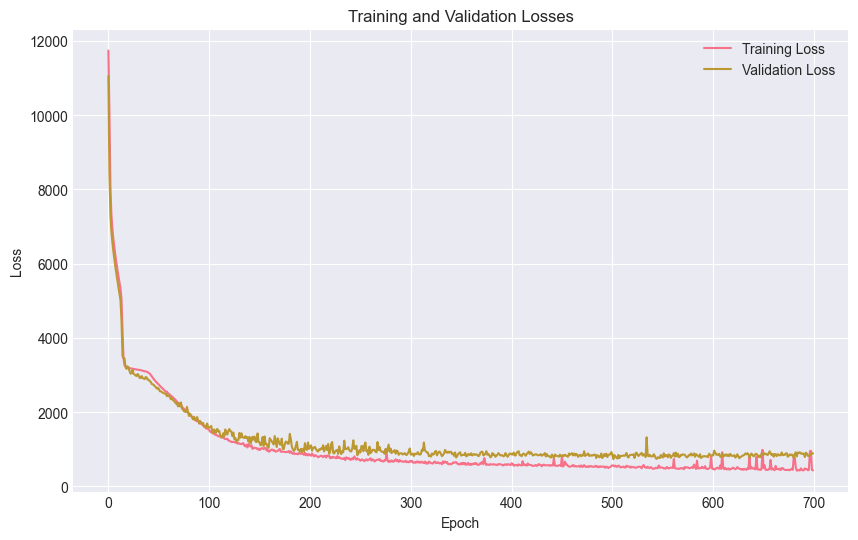

In [46]:
from src.util import resume_training

epochs = 700
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
# start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch800.pth', model, optimizer)

print(f"Resumed from epoch: {start_epoch}")
print(f"checkpoint_path: {checkpoint_path}")
plot_model_loss(training_losses, validation_losses)

# re-training

<>:47: SyntaxWarning: invalid escape sequence '\R'
<>:47: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_28468\2248375125.py:47: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'


start_epoch: 1400
Beginning training...
Epoch 1400 | Train: 237.07 | Val: 888.00
Epoch 1401 | Train: 238.32 | Val: 830.42
Epoch 1402 | Train: 233.07 | Val: 910.35
Epoch 1403 | Train: 220.93 | Val: 930.19
Epoch 1404 | Train: 223.67 | Val: 931.79
Epoch 1405 | Train: 239.77 | Val: 930.95
Epoch 1406 | Train: 242.87 | Val: 886.62
Epoch 1407 | Train: 230.58 | Val: 936.18
Epoch 1408 | Train: 278.88 | Val: 930.99
Epoch 1409 | Train: 238.18 | Val: 926.14
Epoch 1410 | Train: 226.68 | Val: 948.07
Epoch 1411 | Train: 218.32 | Val: 896.37
Epoch 1412 | Train: 225.06 | Val: 929.16
Epoch 1413 | Train: 232.31 | Val: 926.87
Epoch 1414 | Train: 230.18 | Val: 938.72
Epoch 1415 | Train: 232.19 | Val: 928.22
Epoch 1416 | Train: 229.32 | Val: 930.59
Epoch 1417 | Train: 233.32 | Val: 898.60
Epoch 1418 | Train: 242.80 | Val: 881.33
Epoch 1419 | Train: 216.97 | Val: 906.47
Checkpoint saved at epoch 1420 in the file: checkpoint\RNN_VAE_lat16_hid128_gru4_val_uncert_v20251213\RNN_VAE_checkpoint_epoch1420.pth
Model

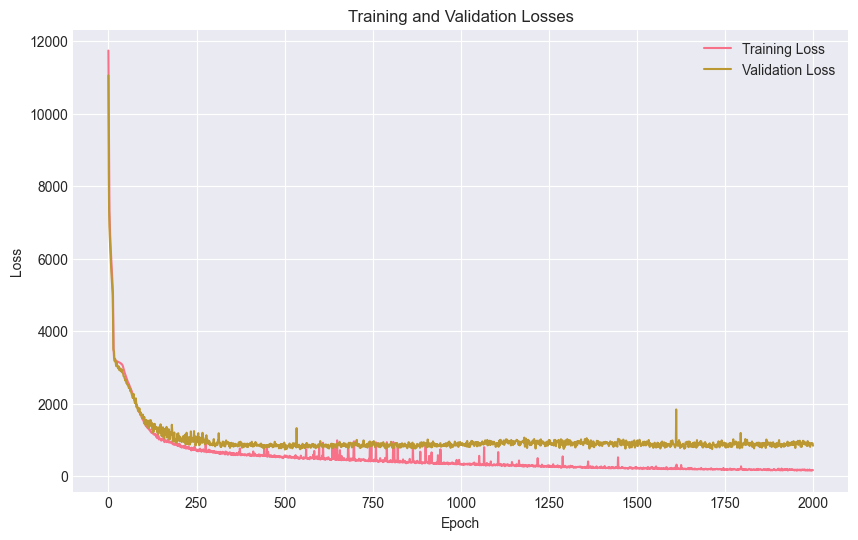

In [17]:
print(f"start_epoch: {start_epoch}")

# Continue training loop from start_epoch
print("Beginning training...")

for epoch in range(start_epoch, 2000):
    # set to training mode
    model.train()
    train_loss = 0
    
    for x, uncertainties, weights, labels, ids, lengths in train_loader:
        x = x.to(device)
        weights = weights.to(device)
        
        x_hat, mu, logvar = model(x, lengths)
        loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    training_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in val_loader:
            x = x.to(device)
            weights = weights.to(device)
            
            x_hat, mu, logvar = model(x, lengths)
            loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    validation_losses.append(avg_val_loss)

    print(f'Epoch {epoch} | Train: {avg_train_loss:.2f} | Val: {avg_val_loss:.2f}')

        # Save model checkpoint every checkpoint_increment epochs
    if (epoch + 1) % checkpoint_increment == 0:
        checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'
        save_checkpoint(epoch+1, model, optimizer, avg_train_loss, avg_val_loss, training_losses, validation_losses, path=checkpoint_path_file)
        print(f'Model checkpoint saved at {checkpoint_path_file}')

plot_model_loss(training_losses, validation_losses)


# Calculate latent space


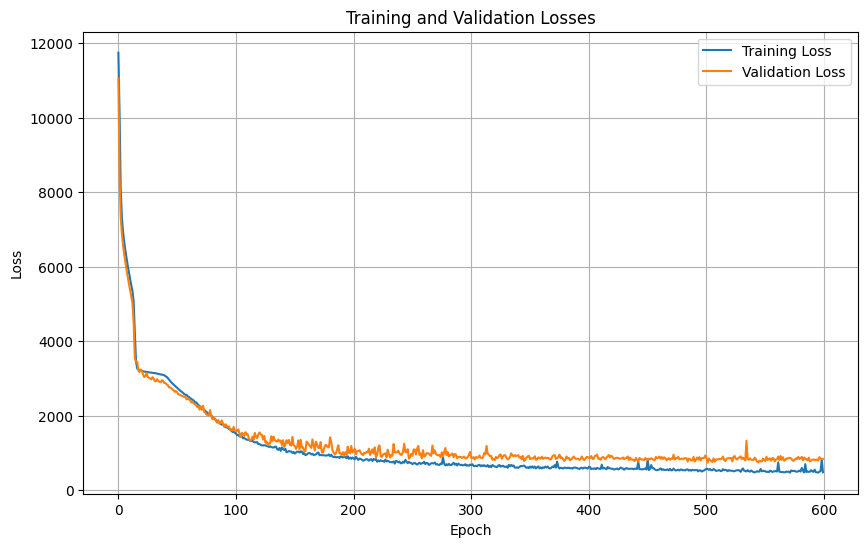

In [21]:
plot_model_loss(training_losses, validation_losses)


# Latent space analysis #1

k:\victor\python-project\torchenv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


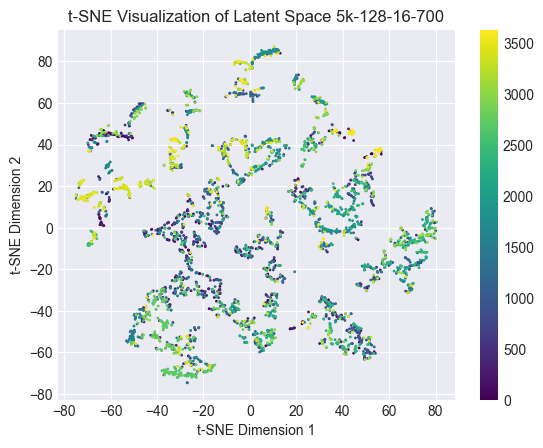

In [47]:
####### get latent features
# start_epoch = 1000
import numpy as np
import torch.nn.utils.rnn as rnn

def get_clustered_data(model, data_loader):
  # Get latent representations for all data points
  with torch.no_grad():
    all_mus = []
    labels_latent = []

    for x, uncertainties, weights, labels, ids, lengths in data_loader:
        x = x.to(device)
        weights = weights.to(device)
        encoded, mu, logvar = model(x, lengths)
        all_mus.append(mu.to(device))
        labels_latent.append(labels.to(device))
        # print(labels)

    latent_data = torch.cat(all_mus, dim=0)
    latent_label = torch.cat(labels_latent, dim=0)

    return latent_data, latent_label


def tsne_transform(latent_space, latent_label):
  # Assuming you have a latent space representation in a NumPy array:

  # latent_space = X

  # Reduce dimensionality to 2D using t-SNE
  tsne = TSNE(n_components=2, perplexity=20, learning_rate=200, random_state=40, n_iter=1000)
  latent_space_2d = tsne.fit_transform(latent_space)


  # Plot the 2D representation
  plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], s=1, c=latent_label, cmap='viridis')
  plt.colorbar()

  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.title(f't-SNE Visualization of Latent Space 5k-{hidden_size}-{latent_size}-{start_epoch}')

  plt.show()

# latent data
clustered_latent_data, clustered_latent_label = get_clustered_data(model, all_loader_no_shuffle)

X = clustered_latent_data.cpu().numpy()
latent_label = clustered_latent_label.cpu().numpy()
tsne_transform(X, latent_label)



# HDBSCAN #2
# optimize min_samples_range, fix min_cluster_size=10



min_samples=3 -> Found 7 anomalies (Score > 0.8)
min_samples=4 -> Found 8 anomalies (Score > 0.8)
min_samples=5 -> Found 15 anomalies (Score > 0.8)
min_samples=6 -> Found 19 anomalies (Score > 0.8)
min_samples=7 -> Found 20 anomalies (Score > 0.8)
min_samples=8 -> Found 21 anomalies (Score > 0.8)
min_samples=9 -> Found 40 anomalies (Score > 0.8)
min_samples=10 -> Found 44 anomalies (Score > 0.8)
min_samples=11 -> Found 58 anomalies (Score > 0.8)
min_samples=12 -> Found 56 anomalies (Score > 0.8)
min_samples=13 -> Found 53 anomalies (Score > 0.8)
min_samples=14 -> Found 53 anomalies (Score > 0.8)
min_samples=15 -> Found 53 anomalies (Score > 0.8)
min_samples=16 -> Found 56 anomalies (Score > 0.8)
min_samples=17 -> Found 57 anomalies (Score > 0.8)
min_samples=18 -> Found 55 anomalies (Score > 0.8)
min_samples=19 -> Found 55 anomalies (Score > 0.8)
min_samples=20 -> Found 55 anomalies (Score > 0.8)
min_samples=21 -> Found 88 anomalies (Score > 0.8)
min_samples=22 -> Found 56 anomalies (Sc

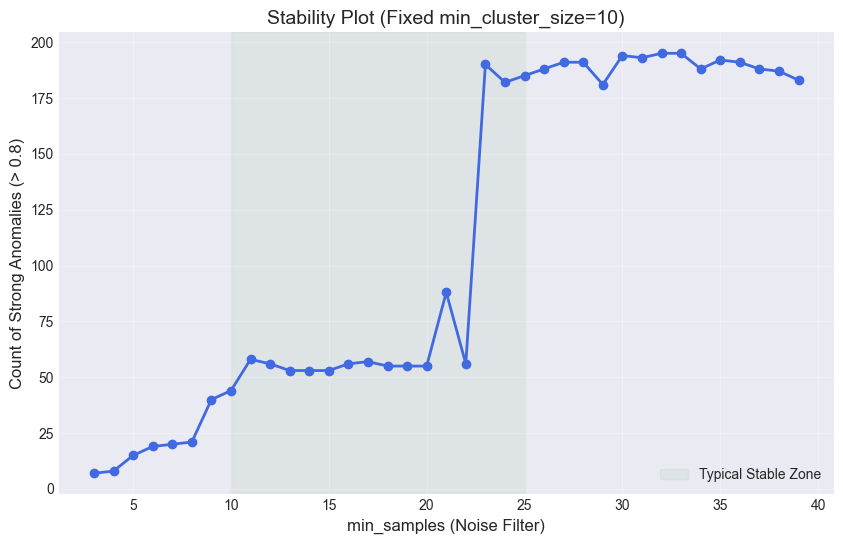

[(3, 7),
 (4, 8),
 (5, 15),
 (6, 19),
 (7, 20),
 (8, 21),
 (9, 40),
 (10, 44),
 (11, 58),
 (12, 56),
 (13, 53),
 (14, 53),
 (15, 53),
 (16, 56),
 (17, 57),
 (18, 55),
 (19, 55),
 (20, 55),
 (21, 88),
 (22, 56),
 (23, 190),
 (24, 182),
 (25, 185),
 (26, 188),
 (27, 191),
 (28, 191),
 (29, 181),
 (30, 194),
 (31, 193),
 (32, 195),
 (33, 195),
 (34, 188),
 (35, 192),
 (36, 191),
 (37, 188),
 (38, 187),
 (39, 183)]

In [48]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import warnings

def hdbscan_study_fixed_size(X, min_cluster_size=10, min_samples_range=range(3, 40)):
    """
    Runs HDBSCAN with a fixed min_cluster_size and varying min_samples.
    Returns the anomaly counts to help identify the 'Stability Plateau'.
    """
    warnings.filterwarnings('ignore')
    
    results = []
    
    # Iterate ONLY over min_samples
    for min_samples in min_samples_range:
        
        # 1. Initialize and Fit
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size, # FIXED at 10
            min_samples=min_samples,           # VARYING
            metric='euclidean',
            cluster_selection_method='eom', 
            allow_single_cluster=True
        )
        
        clusterer.fit(X)
        
        # 2. Calculate Anomalies (Robust Threshold Method)
        # We use a fixed scientific threshold (0.8) to see how the model behavior changes.
        # If we used a percentile (e.g. top 1%), the count would be constant, hiding the physics.
        scores = clusterer.outlier_scores_
        threshold = 0.80
        
        anomaly_indices = np.where(scores > threshold)[0]
        count = len(anomaly_indices)
        
        results.append((min_samples, count))
        print(f"min_samples={min_samples} -> Found {count} anomalies (Score > {threshold})")

    # Unpack for plotting
    x_vals = [r[0] for r in results]
    y_vals = [r[1] for r in results]

    # 3. Plot the Curve
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, y_vals, 'o-', linewidth=2, color='royalblue')
    
    # Add visual guide for the "Plateau"
    plt.xlabel('min_samples (Noise Filter)', fontsize=12)
    plt.ylabel(f'Count of Strong Anomalies (> {threshold})', fontsize=12)
    plt.title(f'Stability Plot (Fixed min_cluster_size={min_cluster_size})', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Highlight the likely optimal zone (visual aid)
    plt.axvspan(10, 25, color='green', alpha=0.05, label='Typical Stable Zone')
    plt.legend()
    
    plt.show()
    
    return results

hdbscan_study_fixed_size(X)
# --- USAGE ---
# results = hdbscan_study_fixed_size(my_features, min_cluster_size=10)

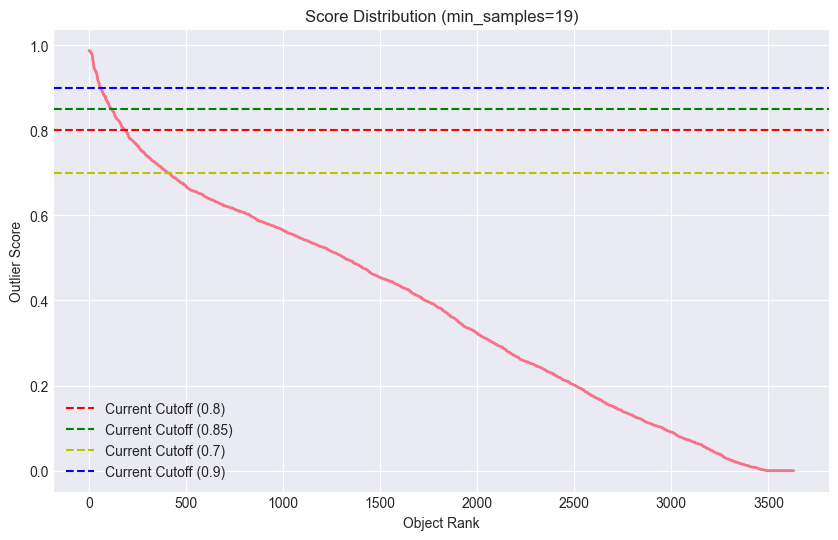

In [49]:
import matplotlib.pyplot as plt
import numpy as np

min_cluster_size=10 # FIXED at 10
min_samples = 23

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size, # FIXED at 10
    min_samples=min_samples,           # VARYING
    # metric='euclidean',
    cluster_selection_method='eom', 
    allow_single_cluster=True
)

clusterer.fit(X)
# Use your trained clusterer
scores = clusterer.outlier_scores_

# Sort scores high to low
sorted_scores = np.sort(scores)[::-1]

plt.figure(figsize=(10, 6))
plt.plot(sorted_scores, linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', label='Current Cutoff (0.8)')
plt.axhline(y=0.85, color='g', linestyle='--', label='Current Cutoff (0.85)')
plt.axhline(y=0.7, color='y', linestyle='--', label='Current Cutoff (0.7)')
plt.axhline(y=0.9, color='b', linestyle='--', label='Current Cutoff (0.9)')
plt.ylabel("Outlier Score")
plt.xlabel("Object Rank")
plt.title("Score Distribution (min_samples=19)")
plt.legend()
plt.show()

In [50]:
threshold = 0.8

anomaly_indices = np.where(scores > threshold)[0]
# count = len(anomaly_indices)

print(f"""For min_samples = {min_samples}, min_cluster_size = {min_cluster_size}, threshold = {threshold}, epoch = {start_epoch}, the size of anomalies = {len(anomaly_indices)}""")
# print(anomaly_indices)
indices = np.array(latent_label[anomaly_indices]).flatten()
list2 = [int(i) for i in sorted(indices)]

# For min_samples = 20, min_cluster_size = 10, threshold = 0.85, the size of anomalies = 56
# For min_samples = 22, min_cluster_size = 10, threshold = 0.7, the size of anomalies = 58
# For min_samples = 25, min_cluster_size = 10, threshold = 0.8, the size of anomalies = 179
# For min_samples = 21, min_cluster_size = 10, threshold = 0.8, the size of anomalies = 150
# For min_samples = 18, min_cluster_size = 10, threshold = 0.8, epoch = 600, the size of anomalies = 161
# For min_samples = 12, min_cluster_size = 10, threshold = 0.8, epoch = 320, the size of anomalies = 173
# For min_samples = 25, min_cluster_size = 10, threshold = 0.8, epoch = 1000, the size of anomalies = 165


For min_samples = 23, min_cluster_size = 10, threshold = 0.8, epoch = 700, the size of anomalies = 190


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Create and fit the Isolation Forest model
# clf = IsolationForest(contamination=0.1)
clf = IsolationForest(contamination=0.09, n_estimators=1000, random_state=42)
clf.fit(X)

# Predict anomalies
y_pred = clf.predict(X)

indices_raw = np.where(y_pred == -1 )
indices = np.array(latent_label[indices_raw])
indices = indices.flatten()
print(len(indices))
print(sorted(indices))
print([int(i) for i in sorted(indices)])
list3 = [int(i) for i in sorted(indices)]

# 263
# [np.int64(1), np.int64(6), np.int64(11), np.int64(12), np.int64(14), np.int64(17), np.int64(29), np.int64(37), np.int64(52), np.int64(75), np.int64(93), np.int64(94), np.int64(109), np.int64(130), np.int64(135), np.int64(136), np.int64(149), np.int64(150), np.int64(159), np.int64(160), np.int64(161), np.int64(169), np.int64(173), np.int64(178), np.int64(181), np.int64(186), np.int64(187), np.int64(196), np.int64(208), np.int64(223), np.int64(234), np.int64(236), np.int64(249), np.int64(255), np.int64(256), np.int64(257), np.int64(261), np.int64(276), np.int64(278), np.int64(284), np.int64(285), np.int64(295), np.int64(299), np.int64(302), np.int64(303), np.int64(312), np.int64(315), np.int64(319), np.int64(324), np.int64(325), np.int64(326), np.int64(328), np.int64(329), np.int64(343), np.int64(352), np.int64(356), np.int64(369), np.int64(371), np.int64(372), np.int64(406), np.int64(407), np.int64(410), np.int64(411), np.int64(420), np.int64(422), np.int64(423), np.int64(430), np.int64(431), np.int64(452), np.int64(454), np.int64(456), np.int64(486), np.int64(488), np.int64(497), np.int64(526), np.int64(533), np.int64(534), np.int64(543), np.int64(546), np.int64(548), np.int64(553), np.int64(560), np.int64(562), np.int64(577), np.int64(586), np.int64(595), np.int64(597), np.int64(598), np.int64(603), np.int64(620), np.int64(621), np.int64(624), np.int64(625), np.int64(634), np.int64(635), np.int64(641), np.int64(645), np.int64(648), np.int64(649), np.int64(658), np.int64(659), np.int64(671), np.int64(675), np.int64(701), np.int64(710), np.int64(729), np.int64(730), np.int64(757), np.int64(779), np.int64(785), np.int64(812), np.int64(818), np.int64(824), np.int64(825), np.int64(906), np.int64(942), np.int64(995), np.int64(1016), np.int64(1021), np.int64(1036), np.int64(1051), np.int64(1054), np.int64(1082), np.int64(1087), np.int64(1090), np.int64(1134), np.int64(1200), np.int64(1201), np.int64(1213), np.int64(1228), np.int64(1236), np.int64(1248), np.int64(1252), np.int64(1285), np.int64(1299), np.int64(1308), np.int64(1312), np.int64(1323), np.int64(1331), np.int64(1339), np.int64(1357), np.int64(1378), np.int64(1382), np.int64(1395), np.int64(1398), np.int64(1409), np.int64(1422), np.int64(1429), np.int64(1435), np.int64(1464), np.int64(1490), np.int64(1493), np.int64(1519), np.int64(1521), np.int64(1527), np.int64(1550), np.int64(1555), np.int64(1567), np.int64(1582), np.int64(1645), np.int64(1716), np.int64(1751), np.int64(1758), np.int64(1770), np.int64(1826), np.int64(1856), np.int64(1858), np.int64(1863), np.int64(1865), np.int64(1870), np.int64(1885), np.int64(1886), np.int64(1941), np.int64(1957), np.int64(1966), np.int64(1971), np.int64(2010), np.int64(2025), np.int64(2033), np.int64(2043), np.int64(2062), np.int64(2066), np.int64(2079), np.int64(2121), np.int64(2175), np.int64(2197), np.int64(2260), np.int64(2264), np.int64(2296), np.int64(2303), np.int64(2312), np.int64(2316), np.int64(2317), np.int64(2318), np.int64(2321), np.int64(2322), np.int64(2323), np.int64(2326), np.int64(2348), np.int64(2361), np.int64(2375), np.int64(2387), np.int64(2388), np.int64(2415), np.int64(2421), np.int64(2460), np.int64(2461), np.int64(2466), np.int64(2467), np.int64(2483), np.int64(2495), np.int64(2508), np.int64(2538), np.int64(2542), np.int64(2543), np.int64(2544), np.int64(2549), np.int64(2550), np.int64(2559), np.int64(2563), np.int64(2565), np.int64(2576), np.int64(2582), np.int64(2590), np.int64(2596), np.int64(2597), np.int64(2608), np.int64(2609), np.int64(2614), np.int64(2615), np.int64(2642), np.int64(2693), np.int64(2695), np.int64(2700), np.int64(2733), np.int64(2773), np.int64(2782), np.int64(2826), np.int64(2855), np.int64(2993), np.int64(3012), np.int64(3080), np.int64(3096), np.int64(3097), np.int64(3134), np.int64(3153), np.int64(3176), np.int64(3304), np.int64(3305), np.int64(3387), np.int64(3408), np.int64(3424), np.int64(3430), np.int64(3437), np.int64(3442), np.int64(3476), np.int64(3477), np.int64(3502), np.int64(3552), np.int64(3564), np.int64(3587), np.int64(3590), np.int64(3613)]
# [1, 6, 11, 12, 14, 17, 29, 37, 52, 75, 93, 94, 109, 130, 135, 136, 149, 150, 159, 160, 161, 169, 173, 178, 181, 186, 187, 196, 208, 223, 234, 236, 249, 255, 256, 257, 261, 276, 278, 284, 285, 295, 299, 302, 303, 312, 315, 319, 324, 325, 326, 328, 329, 343, 352, 356, 369, 371, 372, 406, 407, 410, 411, 420, 422, 423, 430, 431,           452, 454, 456, 486, 488, 497, 526, 533, 534, 543, 546, 548, 553, 560, 562,      577, 586, 595, 597, 598, 603, 620, 621, 624, 625, 634, 635, 641, 645, 648, 649, 658, 659, 671, 675, 701, 710, 729, 730, 757, 779, 785, 812, 818, 824, 825, 906, 942, 995, 1016, 1021, 1036, 1051, 1054, 1082, 1087, 1090, 1134, 1200, 1201, 1213, 1228, 1236, 1248, 1252, 1285, 1299, 1308, 1312, 1323, 1331, 1339, 1357, 1378, 1382, 1395, 1398, 1409, 1422, 1429, 1435,       1464, 1490, 1493, 1519, 1521, 1527, 1550, 1555, 1567, 1582, 1645, 1716, 1751, 1758, 1770, 1826, 1856, 1858, 1863, 1865, 1870, 1885, 1886,       1941, 1957, 1966, 1971, 2010, 2025, 2033, 2043, 2062, 2066, 2079, 2121, 2175, 2197, 2260, 2264, 2296,       2303, 2312, 2316, 2317, 2318, 2321, 2322, 2323, 2326, 2348, 2361, 2375, 2387, 2388, 2415, 2421,       2460, 2461, 2466, 2467, 2483, 2495, 2508,       2538, 2542, 2543, 2544, 2549, 2550, 2559, 2563, 2565,       2576, 2582, 2590, 2596, 2597, 2608, 2609, 2614, 2615, 2642, 2693, 2695, 2700, 2733, 2773, 2782, 2826, 2855, 2993, 3012, 3080, 3096, 3097, 3134, 3153, 3176, 3304, 3305, 3387, 3408, 3424, 3430, 3437, 3442, 3476, 3477, 3502, 3552, 3564, 3587, 3590, 3613]
# [1, 6, 11, 12, 14, 27, 29, 37, 52, 75, 93, 94, 109, 130, 135, 136, 149, 150, 159, 160, 161, 169, 173, 178, 181, 186, 187, 196, 208, 223, 234, 236, 249, 255, 256, 257, 261, 276, 278, 284, 285, 295, 299, 302, 303, 312, 315, 319, 324, 325, 326, 328, 329, 343, 352, 356, 369, 371, 372, 406, 407, 410, 411, 420, 422, 423, 430, 431, 439, 445, 452, 454, 456, 486, 488, 497, 526, 533, 534, 543, 546, 548, 553, 560, 562, 567, 577, 586, 595, 597, 598, 603, 620, 621, 624, 625, 634, 635, 641, 645, 648, 649, 658, 659, 671, 675, 701, 710, 729, 730, 757, 779, 785, 812, 818, 824, 825, 906, 942, 995, 1016, 1021, 1036, 1051, 1054, 1082, 1087, 1090, 1134, 1200, 1201, 1213, 1228, 1236, 1248, 1252, 1285, 1299, 1308, 1312, 1323, 1331, 1339, 1357, 1378, 1382, 1395, 1398, 1409, 1422, 1429, 1435, 1437, 1464, 1490,       1519, 1521, 1527, 1550, 1555, 1567, 1582, 1645, 1716, 1751, 1758, 1770, 1826, 1856, 1858, 1863, 1865, 1870, 1885, 1886, 1915, 1941, 1957, 1966, 1971, 2010, 2025, 2033, 2043, 2062, 2066, 2079, 2121, 2175, 2197, 2260, 2264, 2296, 2299, 2303, 2312, 2316, 2317, 2318, 2321,       2323, 2326, 2348, 2361, 2375, 2387, 2388, 2415, 2421, 2437, 2460, 2461, 2466, 2467, 2483, 2495, 2508, 2535, 2538, 2542, 2543, 2544,       2550, 2559,       2565, 2570, 2576,       2590, 2596, 2597, 2608, 2609,             2642,       2695, 2700, 2733, 2773, 2782, 2826, 2855, 2993, 3012, 3080, 3096, 3097, 3134, 3153, 3176, 3304, 3305, 3387, 3408, 3424, 3430,       3442, 3476, 3477, 3502, 3552, 3564, 3587, 3590, 3613]



327
[np.int64(1), np.int64(2), np.int64(6), np.int64(11), np.int64(12), np.int64(14), np.int64(17), np.int64(23), np.int64(27), np.int64(29), np.int64(37), np.int64(51), np.int64(52), np.int64(60), np.int64(63), np.int64(93), np.int64(94), np.int64(117), np.int64(123), np.int64(127), np.int64(130), np.int64(135), np.int64(136), np.int64(144), np.int64(146), np.int64(150), np.int64(153), np.int64(156), np.int64(159), np.int64(161), np.int64(169), np.int64(173), np.int64(178), np.int64(179), np.int64(181), np.int64(186), np.int64(187), np.int64(193), np.int64(196), np.int64(197), np.int64(200), np.int64(202), np.int64(206), np.int64(208), np.int64(211), np.int64(223), np.int64(224), np.int64(226), np.int64(234), np.int64(236), np.int64(237), np.int64(249), np.int64(255), np.int64(256), np.int64(257), np.int64(260), np.int64(261), np.int64(265), np.int64(269), np.int64(270), np.int64(276), np.int64(278), np.int64(284), np.int64(285), np.int64(294), np.int64(295), np.int64(296), np.int64(2

In [ ]:
def plot_light_curve(df):

    plt.figure(figsize=(12, 5))
    plt.plot(df['relative_time'], df['tess_flux'], '-', alpha=0.2, label='Raw Data')
    
    plt.title(f"light curve for the object {df_exam ['object_name'].values[0]}")
    plt.legend()
    plt.show()

# Re Construction Error Anomaly Detection

### Sensitivity Analysis

In [12]:
def weighted_reconstruction_loss(x_hat, x, weights):
    """
    Compute weighted reconstruction loss per sample
    
    Args:
        x_hat: Reconstructed data (batch_size, seq_len, features)
        x: Original data (batch_size, seq_len, features)
        weights: Weight tensor (batch_size, seq_len, features)
    
    Returns:
        Per-sample reconstruction errors (batch_size,)
    """
    # Apply weights to squared error
    weighted_se = weights * (x_hat - x)**2
    
    # Average across time and features for each sample
    # Keep batch dimension
    per_sample_loss = torch.mean(weighted_se, dim=(1, 2))
    
    return per_sample_loss

def detect_anomalies_with_weights_b1(model, data_loader, threshold_percentile=95, device='cuda'):
    """
    Detect anomalies based on weighted reconstruction error
    Weights are per time step (batch_size, seq_len), not per feature
    """
    model.eval()
    all_recon_errors = []
    all_ids = []
    all_labels = []
    
    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in data_loader:
            x = x.to(device)
            
            # Get reconstruction
            x_hat, mu, logvar = model(x, lengths)
            
            # Compute reconstruction error per time step and feature
            # (batch_size, seq_len, features)
            squared_error = (x_hat - x) ** 2
            
            # Handle weights - they are per time step
            if weights is not None:
                # Weights have shape (batch_size, seq_len)
                # We need to expand to match (batch_size, seq_len, features)
                weights = weights.to(device)
                
                # Add feature dimension and expand to match x shape
                weights_expanded = weights.unsqueeze(-1)  # (batch_size, seq_len, 1)
                weights_expanded = weights_expanded.expand_as(x)  # (batch_size, seq_len, features)
                
                # Apply weights to squared error
                weighted_error = weights_expanded * squared_error
            else:
                weighted_error = squared_error
            
            # Average across time steps and features for each sample
            # This gives one reconstruction error score per sample
            recon_error = torch.mean(weighted_error, dim=(1, 2)).cpu().numpy()
            
            all_recon_errors.extend(recon_error)
            all_ids.extend(ids)
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_recon_errors = np.array(all_recon_errors)
    
    # Set threshold based on percentile
    threshold = np.percentile(all_recon_errors, threshold_percentile)
    
    # Identify anomalies
    is_anomaly = all_recon_errors > threshold
    
    # Create results dictionary
    results = {
        'ids': all_ids,
        'reconstruction_errors': all_recon_errors,
        'anomaly_predictions': is_anomaly,
        'threshold': threshold,
        'labels': all_labels,
        'threshold_percentile': threshold_percentile
    }
    
    return results


def detect_anomalies_with_weights(model, data_loader, threshold_percentile=95, device='cuda'):
    """
    Detect anomalies based on weighted reconstruction error
    Weights are per time step (batch_size, seq_len), not per feature
    """
    model.eval()
    all_recon_errors = []
    all_ids = []
    all_labels = []
    all_original_data = []
    all_reconstructed_data = []
    all_sequence_lengths = []
    # all_weights = []
    
    # max_seq_len = 58  # Assuming this is your fixed padding length
    max_seq_len = max([all_data[item].shape[0] for item in range(len(all_data))])

    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in data_loader:
            x = x.to(device)
            
            # Get reconstruction
            x_hat, mu, logvar = model(x, lengths)
            
            # Store original and reconstructed data
            original_batch = x.cpu().numpy()
            reconstructed_batch = x_hat.cpu().numpy()

            # Ensure all sequences have the same length (58)
            # They should already be padded by DataLoader
            batch_size = original_batch.shape[0]
            if original_batch.shape[1] != max_seq_len:
                # Pad or truncate to max_seq_len
                padded_original = np.zeros((batch_size, max_seq_len, original_batch.shape[2]))
                padded_reconstructed = np.zeros((batch_size, max_seq_len, reconstructed_batch.shape[2]))
                
                for i in range(batch_size):
                    seq_len = min(original_batch.shape[1], max_seq_len)
                    padded_original[i, :seq_len] = original_batch[i, :seq_len]
                    padded_reconstructed[i, :seq_len] = reconstructed_batch[i, :seq_len]
                
                original_batch = padded_original
                reconstructed_batch = padded_reconstructed

            # Compute reconstruction error per time step and feature
            # (batch_size, seq_len, features)
            squared_error = (x_hat - x) ** 2
            
            # Handle weights - they are per time step
            if weights is not None:
                # Weights have shape (batch_size, seq_len)
                # We need to expand to match (batch_size, seq_len, features)
                weights = weights.to(device)
                
                # Add feature dimension and expand to match x shape
                weights_expanded = weights.unsqueeze(-1)  # (batch_size, seq_len, 1)
                weights_expanded = weights_expanded.expand_as(x)  # (batch_size, seq_len, features)
                
                # Apply weights to squared error
                weighted_error = weights_expanded * squared_error
            else:
                weighted_error = squared_error
            
            # Average across time steps and features for each sample
            # This gives one reconstruction error score per sample
            recon_error = torch.mean(weighted_error, dim=(1, 2)).cpu().numpy()
            
            all_recon_errors.extend(recon_error)
            all_ids.extend(ids)
            all_labels.extend(labels.cpu().numpy())

            all_original_data.extend(original_batch)
            all_reconstructed_data.extend(reconstructed_batch)
            all_sequence_lengths.extend(lengths.cpu().numpy())

    
    # Convert to numpy arrays
    all_recon_errors = np.array(all_recon_errors)
    all_original_data = np.array(all_original_data)
    all_reconstructed_data = np.array(all_reconstructed_data)
    all_sequence_lengths = np.array(all_sequence_lengths)
    all_labels = np.array(all_labels)

    # Set threshold based on percentile
    threshold = np.percentile(all_recon_errors, threshold_percentile)
    
    # Identify anomalies
    is_anomaly = all_recon_errors > threshold
    
    # Create results dictionary
    results = {
        'ids': all_ids,
        'reconstruction_errors': all_recon_errors,
        'anomaly_predictions': is_anomaly,
        'threshold': threshold,
        'labels': all_labels,
        'original_data': all_original_data,
        'reconstructed_data': all_reconstructed_data,
        'sequence_lengths': all_sequence_lengths,
        'weights': all_weights,
        'threshold_percentile': threshold_percentile
    }
    
    return results


def detect_anomalies_with_weights_bak(model, data_loader, threshold_percentile=95, device='cuda'):
    """
    Detect anomalies based on weighted reconstruction error
    Weights are per time step (batch_size, seq_len), not per feature
    
    Returns:
        results dictionary containing:
        - ids: sample identifiers
        - reconstruction_errors: per-sample reconstruction errors
        - anomaly_predictions: boolean array indicating anomalies
        - threshold: computed anomaly threshold
        - labels: ground truth labels
        - original_data: original input sequences
        - reconstructed_data: reconstructed sequences
        - sequence_lengths: actual sequence lengths (before padding)
        - weights: uncertainty weights
    """
    model.eval()
    all_recon_errors = []
    all_ids = []
    all_labels = []
    all_original_data = []
    all_reconstructed_data = []
    all_sequence_lengths = []
    all_weights = []
    
    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in data_loader:
            x = x.to(device)
            
            # Get reconstruction
            x_hat, mu, logvar = model(x, lengths)
            
            # Store original and reconstructed data
            original_batch = x.cpu().numpy()
            reconstructed_batch = x_hat.cpu().numpy()
            
            # Compute reconstruction error per time step and feature
            # (batch_size, seq_len, features)
            squared_error = (x_hat - x) ** 2
            
            # Handle weights - they are per time step
            if weights is not None:
                # Weights have shape (batch_size, seq_len)
                # We need to expand to match (batch_size, seq_len, features)
                weights = weights.to(device)
                
                # Add feature dimension and expand to match x shape
                weights_expanded = weights.unsqueeze(-1)  # (batch_size, seq_len, 1)
                weights_expanded = weights_expanded.expand_as(x)  # (batch_size, seq_len, features)
                
                # Apply weights to squared error
                weighted_error = weights_expanded * squared_error
            else:
                weighted_error = squared_error
            
            # Average across time steps and features for each sample
            # This gives one reconstruction error score per sample
            recon_error = torch.mean(weighted_error, dim=(1, 2)).cpu().numpy()
            
            # Store all data
            all_recon_errors.extend(recon_error)
            all_ids.extend(ids)
            all_labels.extend(labels.cpu().numpy())
            # all_original_data.extend(original_batch)
            # all_reconstructed_data.extend(reconstructed_batch)
            all_sequence_lengths.extend(lengths.cpu().numpy())
            if weights is not None:
                all_weights.extend(weights.cpu().numpy())
            else:
                all_weights.extend([None] * len(ids))
    
    # Convert to numpy arrays
    all_recon_errors = np.array(all_recon_errors)
    # all_original_data = np.array(all_original_data)
    # all_reconstructed_data = np.array(all_reconstructed_data)
    all_sequence_lengths = np.array(all_sequence_lengths)
    all_labels = np.array(all_labels)
    
    # Set threshold based on percentile
    threshold = np.percentile(all_recon_errors, threshold_percentile)
    
    # Identify anomalies
    is_anomaly = all_recon_errors > threshold
    
    # Create results dictionary
    results = {
        'ids': all_ids,
        'reconstruction_errors': all_recon_errors,
        'anomaly_predictions': is_anomaly,
        'threshold': threshold,
        'labels': all_labels,
        'original_data': all_original_data,
        'reconstructed_data': all_reconstructed_data,
        'sequence_lengths': all_sequence_lengths,
        'weights': all_weights,
        'threshold_percentile': threshold_percentile
    }
    
    return results    




Processing epoch 100...
Resumed training from epoch 100
  Epoch 100: Mean reconstruction error = 15.0111

Processing epoch 200...
Resumed training from epoch 200
  Epoch 200: Mean reconstruction error = 9.8060

Processing epoch 300...
Resumed training from epoch 300
  Epoch 300: Mean reconstruction error = 8.5716

Processing epoch 400...
Resumed training from epoch 400
  Epoch 400: Mean reconstruction error = 5.8248

Processing epoch 500...
Resumed training from epoch 500
  Epoch 500: Mean reconstruction error = 9.3870

Processing epoch 600...
Resumed training from epoch 600
  Epoch 600: Mean reconstruction error = 4.7413

Processing epoch 700...
Resumed training from epoch 700
  Epoch 700: Mean reconstruction error = 4.7406

Processing epoch 800...
Resumed training from epoch 800
  Epoch 800: Mean reconstruction error = 4.6918

Processing epoch 900...
Resumed training from epoch 900
  Epoch 900: Mean reconstruction error = 4.0404

Processing epoch 1000...
Resumed training from epoch 

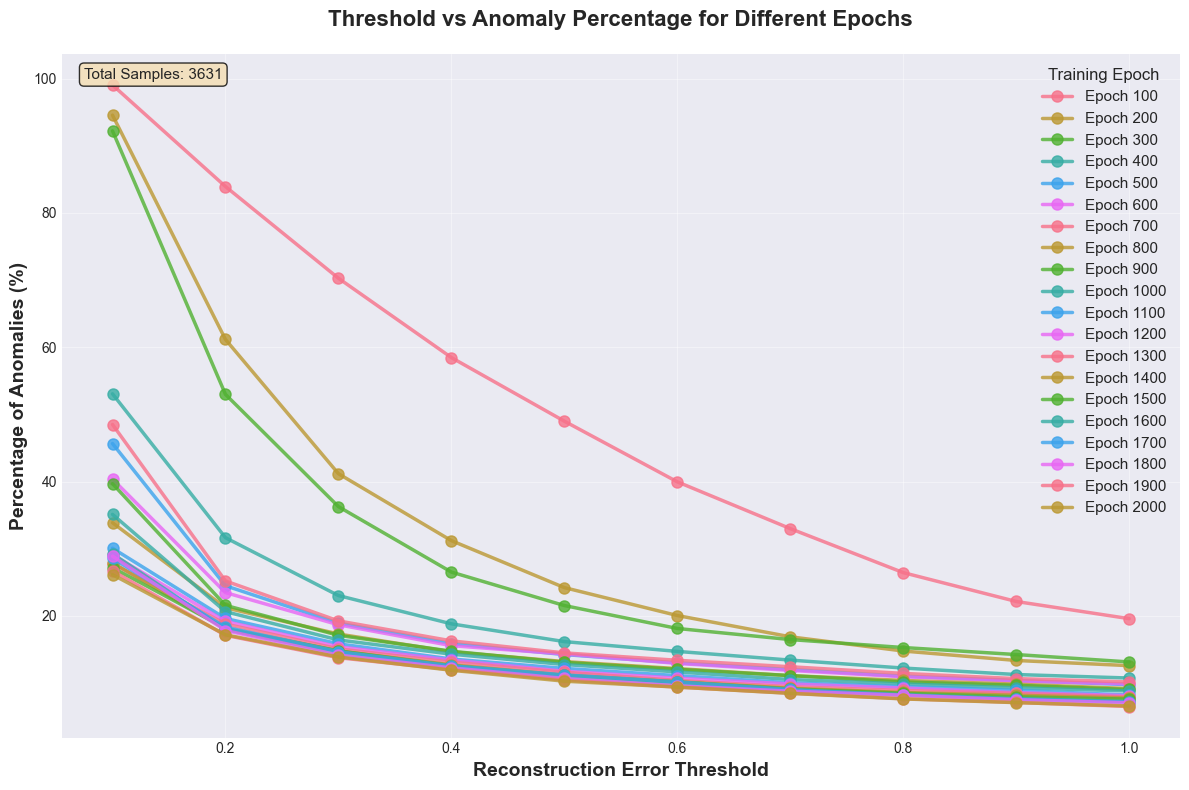

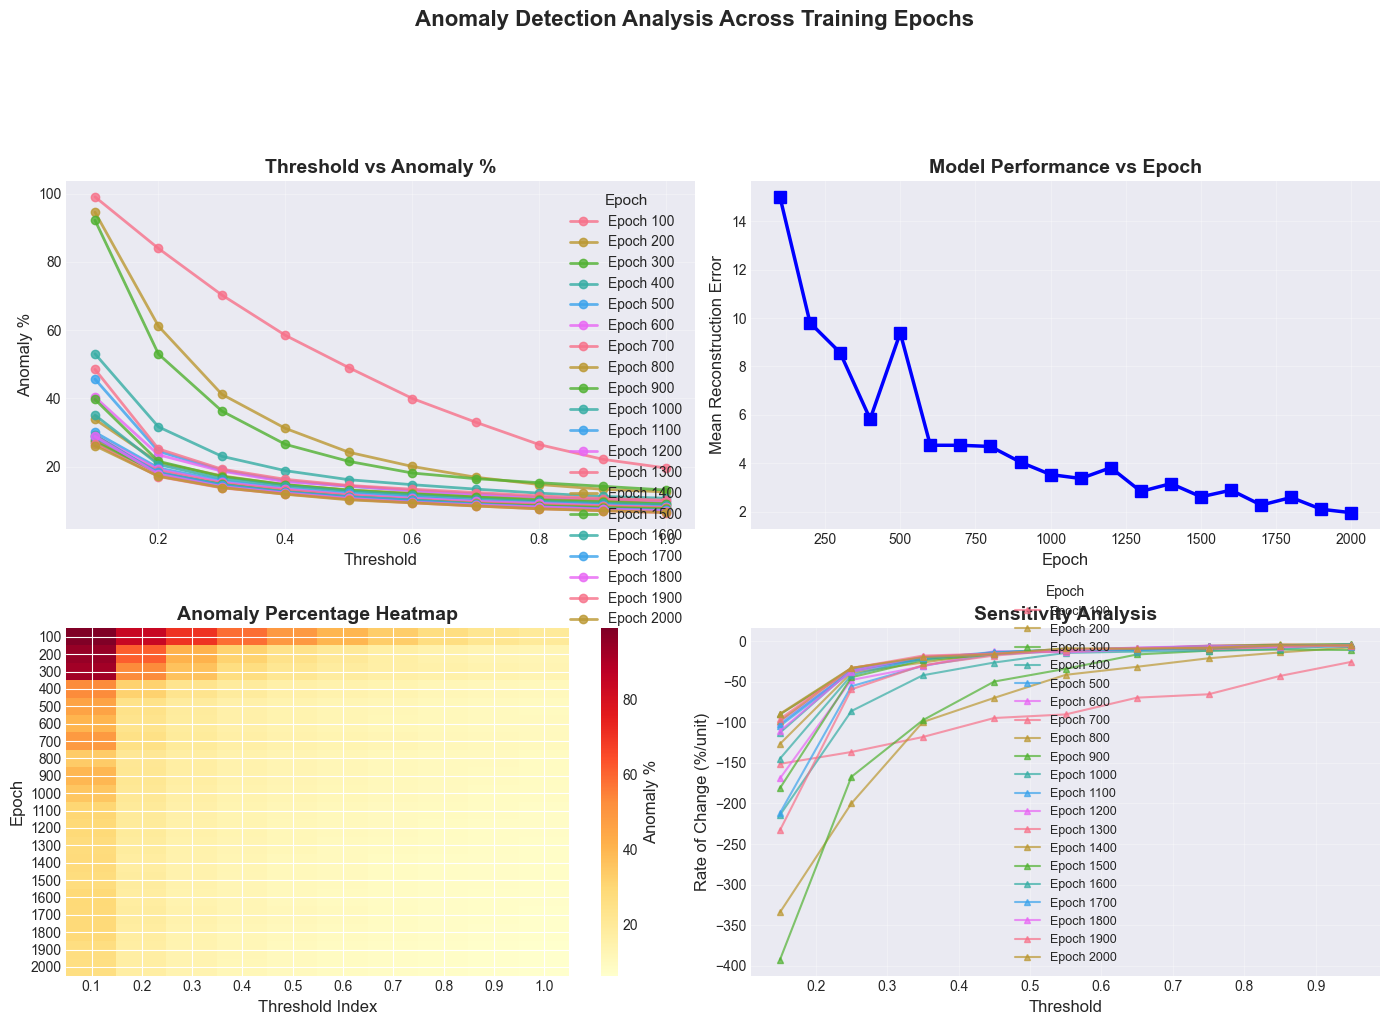


SUMMARY TABLE: Anomaly Percentages by Epoch and Threshold
Epoch     0.1     0.2     0.3     0.4     0.5     0.6     0.7     0.8     0.9     1.0     MeanErr 
--------------------------------------------------------------------------------
100        99.1%   83.9%   70.3%   58.5%   49.0%   40.0%   33.0%   26.4%   22.1%   19.6%  15.0111 
200        94.6%   61.2%   41.2%   31.2%   24.2%   20.0%   16.9%   14.8%   13.4%   12.6%  9.8060  
300        92.2%   53.0%   36.3%   26.5%   21.5%   18.1%   16.5%   15.3%   14.2%   13.1%  8.5716  
400        53.1%   31.6%   23.0%   18.8%   16.2%   14.7%   13.4%   12.2%   11.3%   10.7%  5.8248  
500        45.7%   24.5%   18.9%   15.9%   14.2%   13.0%   12.0%   11.0%   10.4%    9.7%  9.3870  
600        40.4%   23.5%   18.7%   15.6%   14.3%   12.9%   11.9%   10.9%   10.3%    9.9%  4.7413  
700        48.5%   25.2%   19.3%   16.3%   14.5%   13.4%   12.4%   11.4%   10.7%   10.2%  4.7406  
800        33.9%   21.2%   17.3%   14.7%   13.2%   12.1%   11.1%   1

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.util import resume_training


# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Prepare data storage
epoch_results = {}
threshold_values = np.arange(0.1, 1.01, 0.1)  # From 0.1 to 1.0 in steps of 0.1
epochs_to_check = range(100, 2001, 100)

# Loop through epochs

for epoch in epochs_to_check:
    print(f"\nProcessing epoch {epoch}...")
    
    # Resume training and get model state
    start_epoch, training_losses, validation_losses = resume_training(
        f'{checkpoint_path}/RNN_VAE_checkpoint_epoch{epoch}.pth', model, optimizer
    )
    
    # Detect anomalies
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)
    
    # Calculate percentage of anomalies for each threshold
    percentages = []
    total_samples = len(results['reconstruction_errors'])
    
    for threshold in threshold_values:
        anomaly_indices = np.where(results['reconstruction_errors'] > threshold)[0]
        percentage = len(anomaly_indices) / total_samples * 100
        percentages.append(percentage)
    
    # Store results
    epoch_results[epoch] = {
        'thresholds': threshold_values,
        'percentages': np.array(percentages),
        'total_samples': total_samples,
        'model_error_mean': results['reconstruction_errors'].mean(),
        'model_error_std': results['reconstruction_errors'].std()
    }
    
    print(f"  Epoch {epoch}: Mean reconstruction error = {epoch_results[epoch]['model_error_mean']:.4f}")

# Create overlay plot
plt.figure(figsize=(12, 8))

# Plot each epoch's curve
for epoch in epochs_to_check:
    plt.plot(epoch_results[epoch]['thresholds'], 
             epoch_results[epoch]['percentages'],
             marker='o', 
             linewidth=2.5,
             markersize=8,
             label=f'Epoch {epoch}',
             alpha=0.8)

# Customize plot
plt.xlabel('Reconstruction Error Threshold', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Anomalies (%)', fontsize=14, fontweight='bold')
plt.title('Threshold vs Anomaly Percentage for Different Epochs', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(title='Training Epoch', title_fontsize=12, fontsize=11, loc='best')
plt.grid(True, alpha=0.4)

# Add annotation for total samples
total_samples = epoch_results[epochs_to_check[0]]['total_samples']
plt.annotate(f'Total Samples: {total_samples}', 
             xy=(0.02, 0.98), xycoords='axes fraction',
             fontsize=11, ha='left', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Create subplot with additional analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Main overlay plot (top-left)
ax1 = axes[0, 0]
for epoch in epochs_to_check:
    ax1.plot(epoch_results[epoch]['thresholds'], 
             epoch_results[epoch]['percentages'],
             marker='o', linewidth=2, markersize=6,
             label=f'Epoch {epoch}', alpha=0.8)
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Anomaly %', fontsize=12)
ax1.set_title('Threshold vs Anomaly %', fontsize=14, fontweight='bold')
ax1.legend(title='Epoch', fontsize=10, title_fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Model performance vs epoch (top-right)
ax2 = axes[0, 1]
mean_errors = [epoch_results[epoch]['model_error_mean'] for epoch in epochs_to_check]
ax2.plot(epochs_to_check, mean_errors, 'b-', marker='s', linewidth=2.5, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Reconstruction Error', fontsize=12)
ax2.set_title('Model Performance vs Epoch', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Heatmap of anomaly percentages (bottom-left)
ax3 = axes[1, 0]
# Create matrix for heatmap
heatmap_data = np.array([epoch_results[epoch]['percentages'] for epoch in epochs_to_check])
im = ax3.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')
ax3.set_xlabel('Threshold Index', fontsize=12)
ax3.set_ylabel('Epoch', fontsize=12)
ax3.set_title('Anomaly Percentage Heatmap', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(threshold_values)))
ax3.set_xticklabels([f'{t:.1f}' for t in threshold_values])
ax3.set_yticks(range(len(epochs_to_check)))
ax3.set_yticklabels([f'{e}' for e in epochs_to_check])

# Add colorbar
cbar = plt.colorbar(im, ax=ax3)
cbar.set_label('Anomaly %', fontsize=12)

# 4. Rate of change (bottom-right)
ax4 = axes[1, 1]
for epoch in epochs_to_check:
    percentages = epoch_results[epoch]['percentages']
    rate_of_change = np.diff(percentages) / np.diff(threshold_values)
    mid_points = (threshold_values[:-1] + threshold_values[1:]) / 2
    ax4.plot(mid_points, rate_of_change, marker='^', linewidth=1.5, 
             markersize=5, label=f'Epoch {epoch}', alpha=0.7)
ax4.set_xlabel('Threshold', fontsize=12)
ax4.set_ylabel('Rate of Change (%/unit)', fontsize=12)
ax4.set_title('Sensitivity Analysis', fontsize=14, fontweight='bold')
ax4.legend(title='Epoch', fontsize=9, title_fontsize=10)
ax4.grid(True, alpha=0.3)

plt.suptitle('Anomaly Detection Analysis Across Training Epochs', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Create summary table
print("\n" + "="*80)
print("SUMMARY TABLE: Anomaly Percentages by Epoch and Threshold")
print("="*80)

# Header
header = "Epoch".ljust(8)
for thresh in threshold_values:
    header += f"  {thresh:.1f}".ljust(8)
header += "  MeanErr".ljust(10)
print(header)
print("-" * 80)

# Data rows
for epoch in epochs_to_check:
    row = f"{epoch}".ljust(8)
    for i, thresh in enumerate(threshold_values):
        pct = epoch_results[epoch]['percentages'][i]
        row += f"  {pct:5.1f}%".ljust(8)
    mean_err = epoch_results[epoch]['model_error_mean']
    row += f"  {mean_err:.4f}".ljust(10)
    print(row)

print("="*80)

# Save data for further analysis
import pickle

analysis_data = {
    'epoch_results': epoch_results,
    'threshold_values': threshold_values,
    'epochs_to_check': list(epochs_to_check)
}

with open('anomaly_threshold_analysis.pkl', 'wb') as f:
    pickle.dump(analysis_data, f)
print(f"\nAnalysis data saved to 'anomaly_threshold_analysis.pkl'")

# Create interactive plot (if using Jupyter)
try:
    from ipywidgets import interact, widgets
    
    @interact(epoch=widgets.Dropdown(
        options=list(epochs_to_check),
        value=list(epochs_to_check)[0],
        description='Epoch:'
    ))
    def plot_interactive(epoch):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        ax.plot(epoch_results[epoch]['thresholds'], 
                epoch_results[epoch]['percentages'],
                'b-', marker='o', linewidth=2.5, markersize=8)
        
        ax.set_xlabel('Reconstruction Error Threshold', fontsize=12)
        ax.set_ylabel('Percentage of Anomalies (%)', fontsize=12)
        ax.set_title(f'Epoch {epoch}: Threshold vs Anomaly Percentage\n'
                    f'Mean Error: {epoch_results[epoch]["model_error_mean"]:.4f}', 
                    fontsize=14)
        ax.grid(True, alpha=0.3)
        
        # Add threshold markers
        for thresh, pct in zip(epoch_results[epoch]['thresholds'], 
                               epoch_results[epoch]['percentages']):
            ax.annotate(f'{pct:.1f}%', 
                       xy=(thresh, pct),
                       xytext=(0, 10),
                       textcoords='offset points',
                       ha='center',
                       fontsize=9,
                       alpha=0.7)
        
        plt.tight_layout()
        plt.show()
    
    print("\nInteractive plot available. Use the dropdown to select different epochs.")
except ImportError:
    print("\nNote: Install ipywidgets for interactive plots: pip install ipywidgets")

### end

In [58]:
epochs = 700
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)

results  = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device='cuda')

anomaly_indices = np.where(results['reconstruction_errors'] > 0.5)[0]
# print(anomaly_indices)
print(len(anomaly_indices))

all_indices = sorted([results['ids'][anomaly_index].tolist() for anomaly_index in anomaly_indices])
print(all_indices)

label_names = [all_labels[label_index] for label_index in all_indices]
print(label_names)

label_names_800 = label_names

Resumed training from epoch 700


525
[1, 2, 5, 6, 8, 11, 12, 13, 14, 16, 17, 21, 23, 24, 27, 29, 36, 37, 51, 52, 57, 60, 63, 70, 74, 80, 84, 87, 93, 94, 97, 100, 112, 123, 125, 127, 130, 134, 135, 136, 144, 146, 149, 150, 153, 156, 159, 161, 163, 169, 172, 173, 176, 178, 181, 186, 187, 188, 193, 194, 196, 197, 199, 200, 202, 203, 204, 206, 207, 208, 209, 210, 211, 213, 215, 216, 217, 218, 221, 223, 224, 225, 226, 234, 236, 237, 243, 249, 250, 252, 255, 256, 257, 259, 260, 261, 262, 265, 269, 270, 276, 278, 280, 284, 285, 286, 291, 293, 294, 295, 296, 299, 300, 302, 303, 305, 308, 310, 311, 312, 314, 315, 316, 317, 319, 320, 321, 323, 324, 325, 326, 328, 329, 330, 331, 333, 334, 338, 343, 344, 346, 349, 352, 355, 356, 359, 361, 362, 364, 369, 371, 372, 373, 375, 378, 386, 403, 406, 407, 410, 411, 412, 416, 417, 418, 419, 420, 422, 423, 425, 427, 428, 429, 430, 431, 432, 433, 439, 445, 447, 449, 452, 453, 454, 458, 465, 466, 468, 470, 471, 473, 477, 478, 481, 484, 486, 489, 497, 501, 502, 509, 513, 515, 520, 521, 522, 5

In [59]:
set_all = set.intersection(*(set(lst) for lst in [list2, list3, all_indices]))
# set_all = set.intersection(*(set(lst) for lst in [list2, list3]))


print(len(set_all))
print(sorted(set_all))

186
[1, 2, 6, 11, 12, 14, 27, 29, 37, 51, 52, 63, 93, 94, 130, 135, 146, 150, 153, 156, 159, 161, 169, 173, 178, 181, 186, 187, 193, 196, 197, 208, 223, 226, 234, 236, 249, 255, 256, 257, 260, 261, 269, 270, 276, 278, 284, 285, 294, 295, 299, 312, 315, 321, 325, 326, 328, 329, 333, 343, 352, 356, 369, 371, 372, 410, 411, 420, 422, 423, 430, 431, 439, 447, 452, 486, 497, 521, 526, 533, 534, 543, 546, 553, 577, 586, 595, 601, 603, 621, 625, 635, 641, 645, 648, 649, 658, 671, 675, 695, 728, 729, 730, 735, 757, 779, 785, 812, 814, 825, 995, 996, 1008, 1029, 1054, 1062, 1087, 1129, 1138, 1201, 1213, 1228, 1236, 1285, 1291, 1308, 1312, 1323, 1330, 1331, 1339, 1346, 1358, 1378, 1395, 1398, 1407, 1409, 1422, 1429, 1435, 1464, 1487, 1519, 1527, 1550, 1555, 1582, 1716, 1822, 1835, 1856, 1858, 1863, 1971, 2033, 2043, 2062, 2260, 2264, 2348, 2371, 2387, 2461, 2483, 2495, 2508, 2538, 2543, 2544, 2570, 2596, 2597, 2608, 2638, 2695, 2700, 2733, 2756, 2849, 3076, 3096, 3435, 3442, 3463, 3613]


In [60]:
186/525

0.35428571428571426

# plot al anomaly light curves

In [29]:
epochs = 800
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)

results  = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device='cuda')

anomaly_indices = np.where(results['reconstruction_errors'] > 0.5)[0]
anomaly_indices = np.where(results['reconstruction_errors'] < 0.01)[0]
# anomaly_indices = np.where((results['reconstruction_errors'] > 0.3) & (results['reconstruction_errors'] < 0.32))[0]
# anomaly_indices = np.where(~results['anomaly_predictions'])[0]
print(anomaly_indices)
print(len(anomaly_indices))

all_indices = sorted([results['ids'][anomaly_index] for anomaly_index in anomaly_indices])
print(all_indices)

label_names = [all_labels[label_index] for label_index in all_indices]
print(label_names)



<>:2: SyntaxWarning: invalid escape sequence '\R'
<>:2: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_28468\537216527.py:2: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 800
[  82 1363 1381 1673 2152 2159]
6
[tensor(2418), tensor(2872), tensor(2895), tensor(2941), tensor(2996), tensor(3073)]
['2021egm', '2021xdl', '2021xib', '2021xqs', '2021yfl', '2021yyx']


Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58
Resumed training from epoch 1100
Epoch 1100 - Padded length: 58
Resumed training from epoch 1200
Epoch 1200 - Padded length: 58
Resumed training from epoch 1300
Epoch 1300 - Padded length: 58
Resumed training from epoch 1400
Epoch 1400 - Padded length: 58


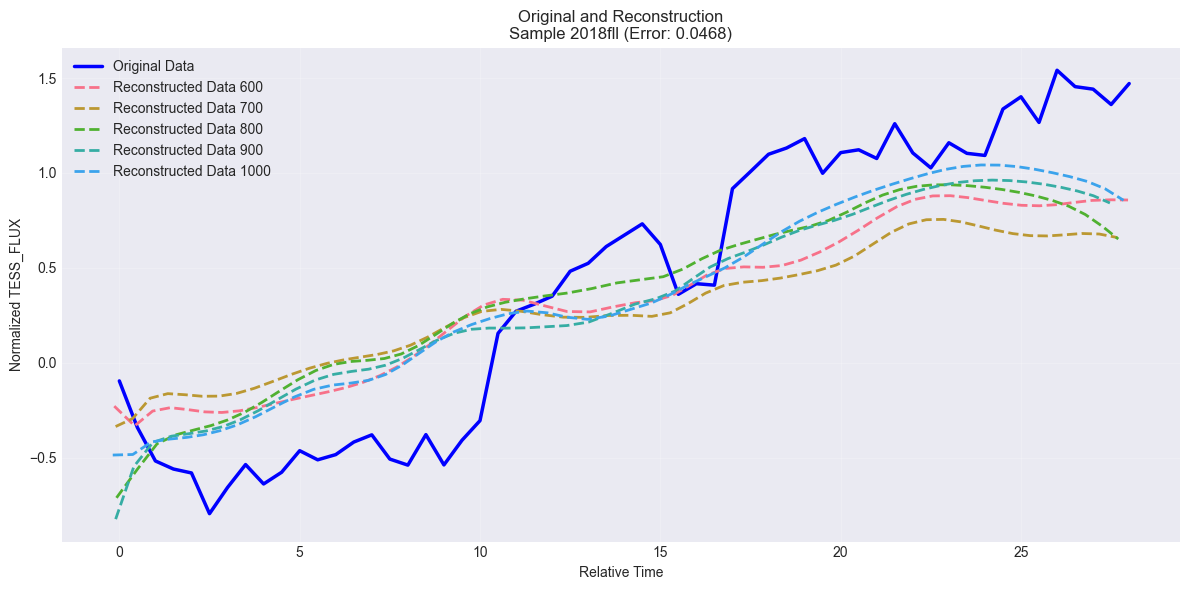

In [62]:
label_name = '2019pkz'
label_name = '2021iff'
label_name = '2018fll'

recon_data_all = {}
orig_data = []

for epochs in range(600, 1401, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data

# Minimalist clean overlap plot
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()

Resumed training from epoch 400
Epoch 400 - Padded length: 58
Resumed training from epoch 500
Epoch 500 - Padded length: 58
Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58


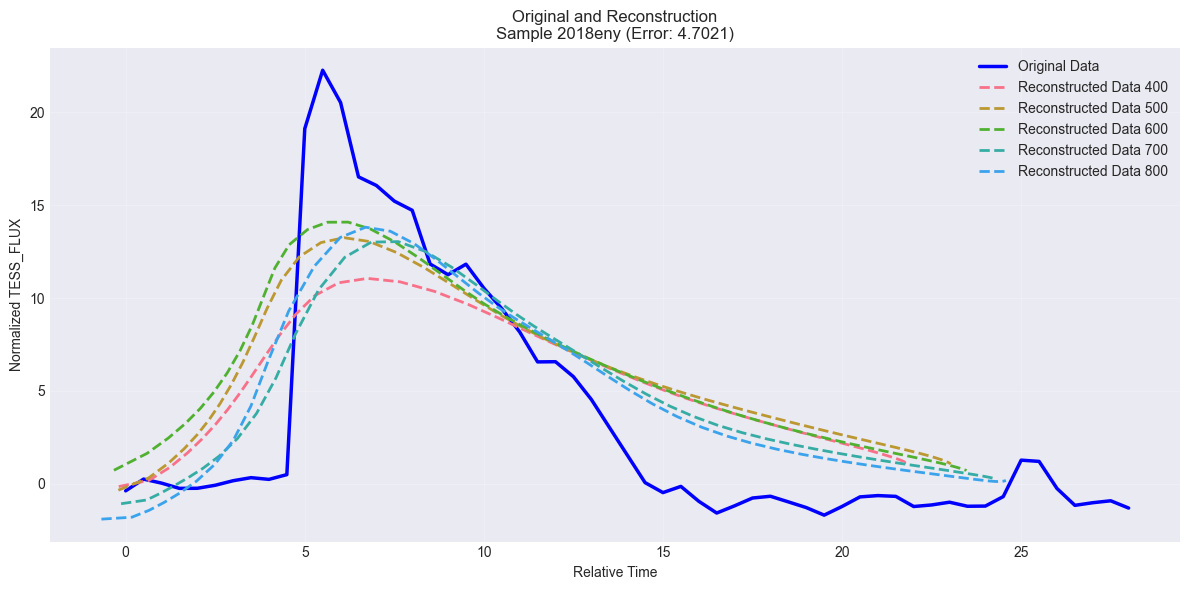

In [61]:
label_name = '2018hql'
label_name = '2018eny'

recon_data_all = {}
orig_data = []

for epochs in range(400, 801, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data

# Minimalist clean overlap plot
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()

Resumed training from epoch 400
Epoch 400 - Padded length: 58
Resumed training from epoch 500
Epoch 500 - Padded length: 58
Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58


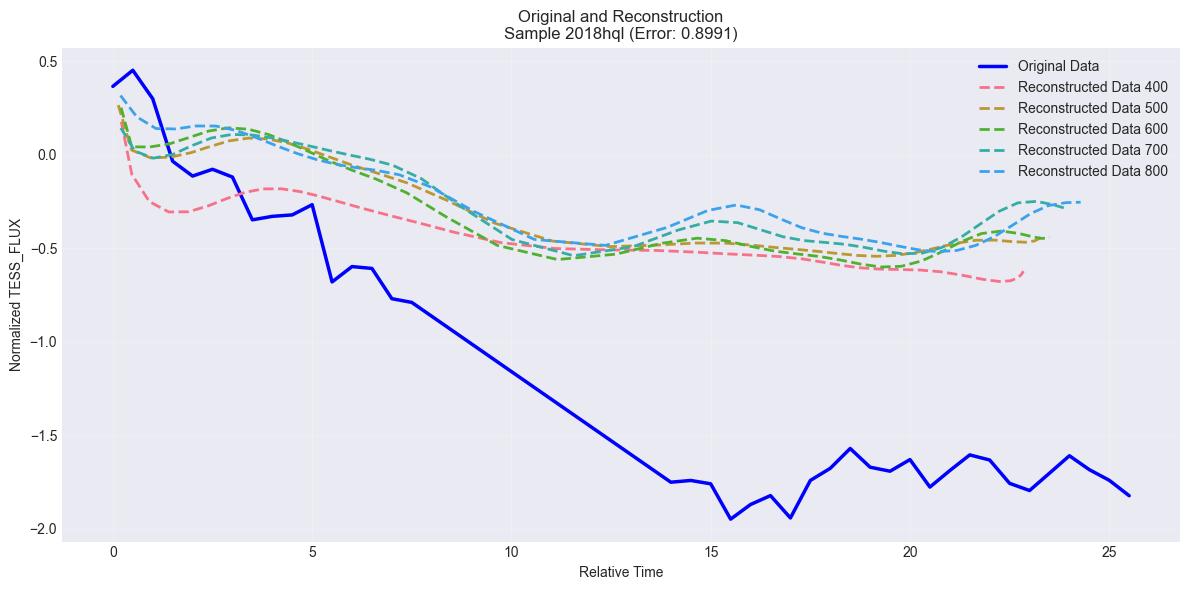

In [53]:
label_name = '2019pkz'
label_name = '2018emt'
label_name = '2018hql'
# label_name = '2018fll'
# label_name = '2022din'

recon_data_all = {}
orig_data = []

for epochs in range(400, 801, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data

# Minimalist clean overlap plot
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    # if (epochs > 800) and (epochs < 400):
    #     continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()

Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58
Resumed training from epoch 1100
Epoch 1100 - Padded length: 58
Resumed training from epoch 1200
Epoch 1200 - Padded length: 58
Resumed training from epoch 1300
Epoch 1300 - Padded length: 58
Resumed training from epoch 1400
Epoch 1400 - Padded length: 58


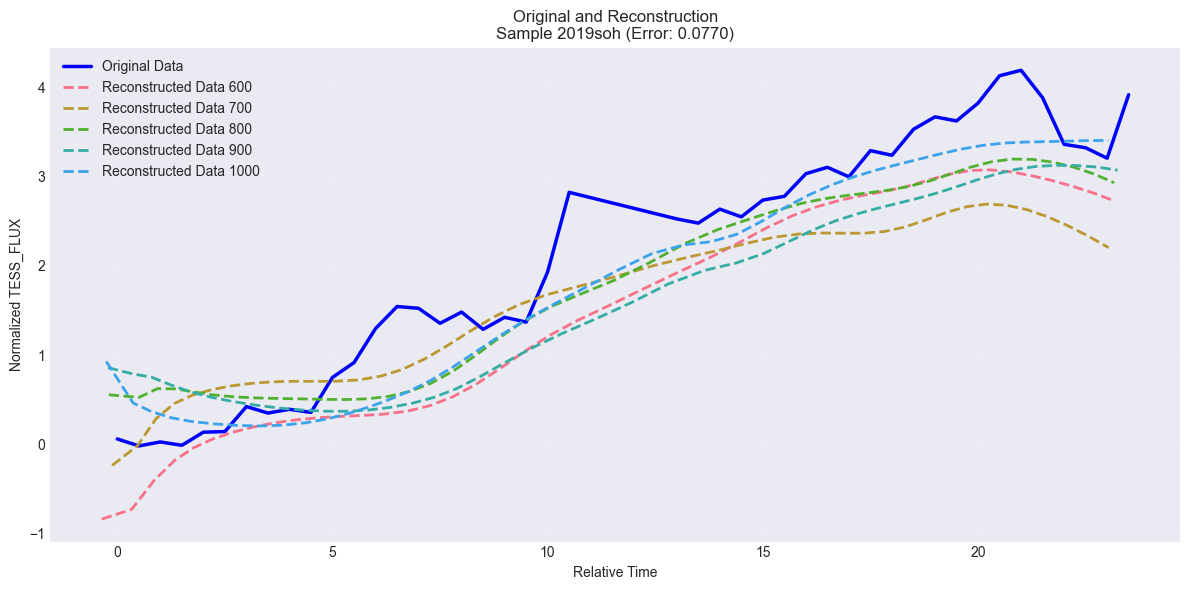

In [63]:
label_name = '2019soh'
recon_data_all = {}
orig_data = []

for epochs in range(600, 1401, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data# Minimalist clean overlap plot
    
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()


<>:8: SyntaxWarning: invalid escape sequence '\R'
<>:8: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_28488\748703246.py:8: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58
Resumed training from epoch 1100
Epoch 1100 - Padded length: 58
Resumed training from epoch 1200
Epoch 1200 - Padded length: 58
Resumed training from epoch 1300
Epoch 1300 - Padded length: 58
Resumed training from epoch 1400
Epoch 1400 - Padded length: 58


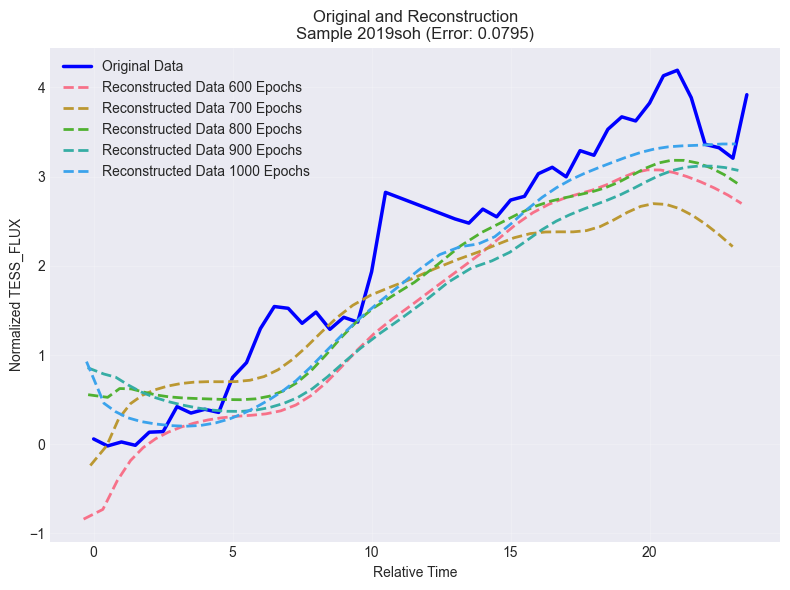

In [17]:
label_name = '2019kli'
label_name = '2019soh'

recon_data_all = {}
orig_data = []

for epochs in range(600, 1401, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data# Minimalist clean overlap plot
    
plt.figure(figsize=(8, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs} Epochs')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()


# Isolation Forest Sensitivity 

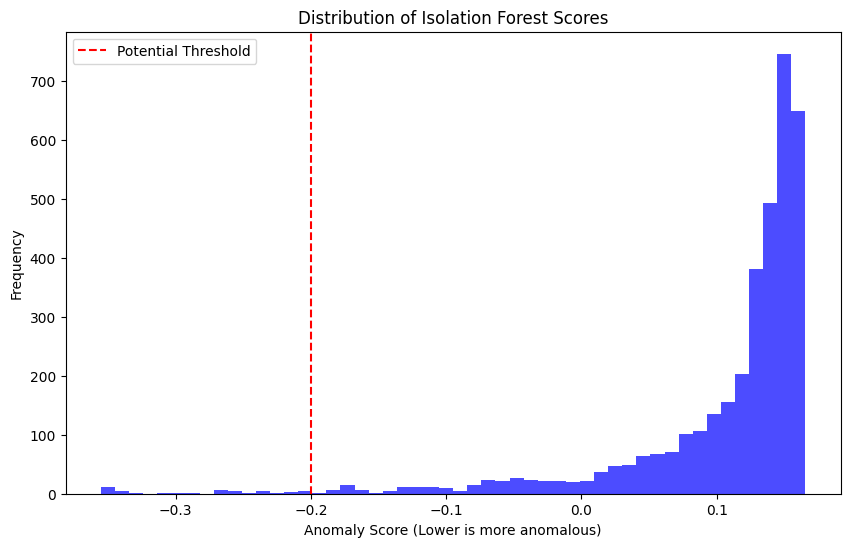

Data-driven contamination based on IQR: 0.0909


In [33]:
def if_score_distribution(X):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.ensemble import IsolationForest

    # 1. Fit the model
    clf = IsolationForest(contamination='auto', random_state=42)
    clf.fit(X)

    # 2. Get anomaly scores (Lower = more abnormal)
    scores = clf.decision_function(X)

    # 3. Visualization: Plot histogram to find the "Elbow"
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, alpha=0.7, color='blue')
    plt.title("Distribution of Isolation Forest Scores")
    plt.xlabel("Anomaly Score (Lower is more anomalous)")
    plt.ylabel("Frequency")
    plt.axvline(x=-0.2, color='r', linestyle='--', label='Potential Threshold') # Example threshold
    plt.legend()
    plt.show()

    # 4. Statistical selection (e.g., 3 standard deviations or IQR)
    # This calculates what % of data lies beyond a statistical extreme
    q1 = np.percentile(scores, 25)
    q3 = np.percentile(scores, 75)
    iqr = q3 - q1
    threshold = q1 - 1.5 * iqr # Outlier threshold for the scores

    # Calculate the resulting contamination based on this threshold
    implied_contamination = (scores < threshold).mean()
    print(f"Data-driven contamination based on IQR: {implied_contamination:.4f}")

    return implied_contamination

STATISTICAL_CONTAMINATION = if_score_distribution(X)

"Following the reviewer's suggestion, we moved away from arbitrary thresholds and adopted a data-driven approach. We analyzed the distribution of anomaly scores generated by the Isolation Forest on the VAE latent space.By applying the Interquartile Range (IQR) rule (defined as $Q_1 - 1.5 \times IQR$) to the decision function scores, we identified the statistical tail of the distribution. This method yielded an intrinsic contamination parameter of 0.0675. This indicates that approximately 6.75% of the samples exhibit statistically significant deviation from the core latent distribution."

In [34]:
STATISTICAL_CONTAMINATION # =0.1

np.float64(0.09088405397961993)

Data shape (Simulated VAE Latent Vectors): (3631, 16)


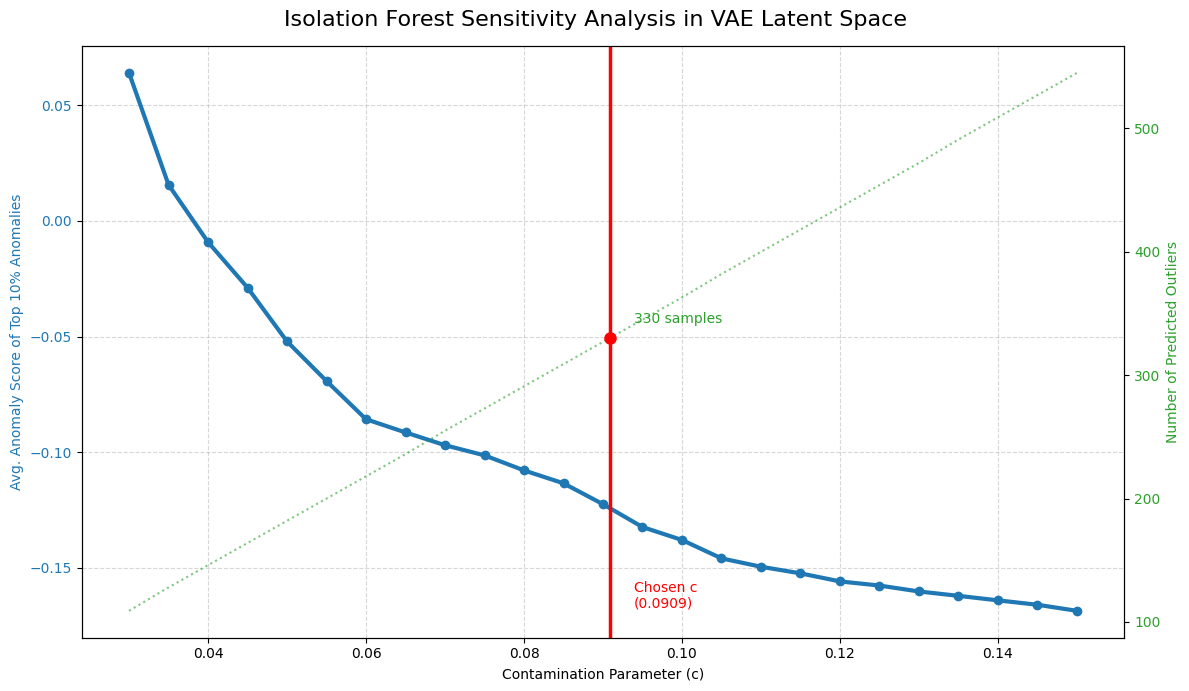

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs

# ==========================================
# CONFIGURATION
# ==========================================
# The contamination parameter derived from your data (IQR method)
# STATISTICAL_CONTAMINATION = 0.1239

# Define the range for the sensitivity analysis plot
# We test from 3% to 15% contamination, centering on 6.75%
CONTAMINATION_RANGE = np.linspace(0.03, 0.15, 25)

# ==========================================
# 1. SETUP: Simulate VAE Latent Vectors
# Replace this section with your actual VAE latent vectors (mu)
# ==========================================
np.random.seed(42)
LATENT_DIM = 16
N_SAMPLES = len(X)

# Simulate a tight cluster of 'normal' VAE latent vectors
# X = np.random.normal(loc=0, scale=1, size=(N_SAMPLES, LATENT_DIM))

# Introduce some true outliers (2% of the data) far from the center
n_outliers = int(N_SAMPLES * 0.02)
outliers = np.random.uniform(low=-8, high=8, size=(n_outliers, LATENT_DIM))
X[:n_outliers] = outliers # Inject them into the dataset

print(f"Data shape (Simulated VAE Latent Vectors): {X.shape}")

# ==========================================
# 2. PERFORM SENSITIVITY ANALYSIS
# ==========================================
# This metric tracks the average intensity of the anomaly signal 
# for a fixed number of the most extreme points, showing signal stability.
avg_top_score_list = []

# Metric 2: The number of points classified as outliers (should be linear)
n_outliers_list = []

# Use a fixed percentage (e.g., top 10%) to measure the signal strength.
TOP_K_PERCENT = 0.10 
top_k = int(N_SAMPLES * TOP_K_PERCENT)

for c in CONTAMINATION_RANGE:
    # 1. Fit the Isolation Forest model
    clf = IsolationForest(contamination=c, random_state=42, n_jobs=-1)
    clf.fit(X)
    
    # 2. Get the anomaly scores (lower score = more anomalous)
    scores = clf.decision_function(X)
    
    # 3. Sort the scores and take the 'Top K' most anomalous scores
    # We sort ascending (lower scores first) and take the first 'top_k' elements
    sorted_scores = np.sort(scores)
    top_k_scores = sorted_scores[:top_k]
    
    # 4. Calculate the average score of these extreme points
    avg_top_score_list.append(np.mean(top_k_scores))

    # 5. Track the number of predicted outliers (should equal c * N_SAMPLES)
    n_outliers_list.append((clf.predict(X) == -1).sum())

# ==========================================
# 3. GENERATE VISUALIZATION
# ==========================================
fig, ax1 = plt.subplots(figsize=(12, 7))
fig.suptitle("Isolation Forest Sensitivity Analysis in VAE Latent Space", fontsize=16)

# --- AXIS 1: Average Anomaly Score (Primary Metric for Robustness) ---
color_score = 'tab:blue'
ax1.set_xlabel('Contamination Parameter (c)')
ax1.set_ylabel(f'Avg. Anomaly Score of Top {TOP_K_PERCENT*100:.0f}% Anomalies', color=color_score)
ax1.plot(CONTAMINATION_RANGE, avg_top_score_list, color=color_score, linewidth=3, marker='o', markersize=6, label='Avg Top K Score')
ax1.tick_params(axis='y', labelcolor=color_score)
ax1.grid(True, linestyle='--', alpha=0.5)

# Highlight the statistically chosen contamination value
ax1.axvline(
    x=STATISTICAL_CONTAMINATION, 
    color='red', 
    linestyle='-', 
    linewidth=2.5, 
    label=f'Data-Driven c = {STATISTICAL_CONTAMINATION:.4f}'
)
# Add a text annotation for the chosen value
ax1.text(
    STATISTICAL_CONTAMINATION + 0.003, 
    min(avg_top_score_list), 
    f'Chosen c\n({STATISTICAL_CONTAMINATION:.4f})', 
    color='red', 
    fontsize=10, 
    verticalalignment='bottom'
)

# --- AXIS 2: Number of Predicted Outliers (Secondary Metric for Context) ---
ax2 = ax1.twinx()  
color_count = 'tab:green'
ax2.set_ylabel('Number of Predicted Outliers', color=color_count)  
ax2.plot(CONTAMINATION_RANGE, n_outliers_list, color=color_count, linestyle=':', alpha=0.6, label='Predicted Outlier Count')
ax2.tick_params(axis='y', labelcolor=color_count)

# Show the predicted count at the chosen contamination level
chosen_count = int(STATISTICAL_CONTAMINATION * N_SAMPLES)
ax2.plot(STATISTICAL_CONTAMINATION, chosen_count, 'ro', markersize=8)
ax2.text(
    STATISTICAL_CONTAMINATION + 0.003, 
    chosen_count + 10, 
    f'{chosen_count} samples', 
    color='tab:green', 
    fontsize=10, 
    verticalalignment='bottom'
)

# Finalize the plot
fig.tight_layout()  # Adjusts plot to prevent labels from overlapping
plt.show()